In [0]:
from __future__ import division
import numpy as np
import random
import string
import os
import tensorflow as tf

def create_variable(name, shape, seed=None):
    ''' Create variable with Xavier initialization '''
    init = tf.contrib.layers.xavier_initializer(seed=seed)
    return tf.get_variable(name=name, shape=shape, initializer=init)

def create_bias_variable(name, shape):
    ''' Create variable with zeros initialization '''
    init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    return tf.get_variable(name=name, shape=shape, initializer=init)

def time_to_batch(inputs, dilation):
    ''' If necessary zero-pads inputs and reshape by dilation '''
    with tf.variable_scope('time_to_batch'):
        _, width, num_channels = inputs.get_shape().as_list()

        width_pad = int(dilation * np.ceil((width + dilation) * 1.0 / dilation))
        pad_left = width_pad - width

        perm = (1, 0, 2)
        shape = (int(width_pad / dilation), -1, num_channels)
        padded = tf.pad(inputs, [[0, 0], [pad_left, 0], [0, 0]])
        transposed = tf.transpose(padded, perm)
        reshaped = tf.reshape(transposed, shape)
        outputs = tf.transpose(reshaped, perm)
        return outputs

def batch_to_time(inputs, dilation, crop_left=0):
    ''' Reshape to 1d signal, and remove excess zero-padding '''
    with tf.variable_scope('batch_to_time'):
        shape = tf.shape(inputs)
        batch_size = shape[0] / dilation
        width = shape[1]
        
        out_width = tf.to_int32(width * dilation)
        _, _, num_channels = inputs.get_shape().as_list()
        
        perm = (1, 0, 2)
        new_shape = (out_width, -1, num_channels) # missing dim: batch_size
        transposed = tf.transpose(inputs, perm)    
        reshaped = tf.reshape(transposed, new_shape)
        outputs = tf.transpose(reshaped, perm)
        cropped = tf.slice(outputs, [0, crop_left, 0], [-1, -1, -1])
        return cropped

def conv1d(inputs, out_channels, filter_width=2, stride=1, padding='VALID', 
        activation=tf.nn.relu, seed=None, bias=True, name='conv1d'):
    ''' Normal 1D convolution operator ''' 
    with tf.variable_scope(name):
        in_channels = inputs.get_shape().as_list()[-1]

        W = create_variable('W', (filter_width, in_channels, out_channels), seed)

        outputs = tf.nn.conv1d(inputs, W, stride=stride, padding=padding)

        if bias:
            b = create_bias_variable('bias', (out_channels, ))
            outputs += tf.expand_dims(tf.expand_dims(b, 0), 0)

        if activation:
            outputs = activation(outputs)

        return outputs

def dilated_conv(inputs, out_channels, filter_width=2, dilation=1, stride=1, 
        padding='VALID', name='dilated_conv', activation=tf.nn.relu, seed=None):
    ''' Warpper for 1D convolution to include dilation '''
    with tf.variable_scope(name):
        width = inputs.get_shape().as_list()[1]

        inputs_ = time_to_batch(inputs, dilation)
        outputs_ = conv1d(inputs_, out_channels, filter_width, stride, padding, activation, seed)

        out_width = outputs_.get_shape().as_list()[1] * dilation
        diff = out_width - width
        outputs = batch_to_time(outputs_, dilation, crop_left=diff)

        # Add additional shape information.
        tensor_shape = [tf.Dimension(None), tf.Dimension(width), tf.Dimension(out_channels)]
        outputs.set_shape(tf.TensorShape(tensor_shape))

        return outputs
    
class Model(object):

    def __init__(self, **params):
        self.num_time_steps = params.get('num_time_steps')
        self.fields = params.get('fields')
        self.num_filters = params.get('num_filters')
        self.num_layers = params.get('num_layers')
        self.learning_rate = params.get('learning_rate', 1e-3)
        self.regularization = params.get('regularization', 1e-2)
        self.n_iter = int(params.get('n_iter'))
        self.logdir = params.get('logdir')
        self.seed = params.get('seed', None)

        assert self.num_layers >= 2, "Must use at least 2 dilation layers"

        self._build_graph()
        
    def _build_graph(self):
        tf.reset_default_graph()

        self.inputs = dict()
        self.targets = dict()

        with tf.variable_scope('input'):
            for f in self.fields:
                self.inputs[f] = tf.placeholder(tf.float32, (None, self.num_time_steps), 'input_%s' % f)
                self.targets[f] = tf.placeholder(tf.float32, (None, self.num_time_steps), 'target_%s' % f)
        
        # Create wavenet for each field being regressed
        self.costs = dict()
        self.optimizers = dict()
        self.outputs = dict()
        for field in self.fields:
            with tf.variable_scope(field):

                # Input layer with conditioning gates
                conditions = list()
                with tf.variable_scope('input_layer'):
                    for k in self.inputs.keys():
                        with tf.variable_scope('condition_%s' % k):
                            dilation = 1
                            X = tf.expand_dims(self.inputs[k], 2)
                            h = dilated_conv(X, self.num_filters, name='input_conv_%s' % k, seed=self.seed)
                            skip = conv1d(X, self.num_filters, filter_width=1, name='skip_%s' % k, 
                                    activation=None, seed=self.seed)
                            conditions.append(h + skip)

                    output = tf.add_n(conditions)

                # Intermediate dilation layers
                with tf.variable_scope('dilated_stack'):
                    for i in range(self.num_layers - 1):
                        with tf.variable_scope('layer_%d' % i):
                            dilation = 2 ** (i + 1)
                            h = dilated_conv(output, self.num_filters, dilation=dilation, name='dilated_conv', 
                                    seed=self.seed)
                            output = h + output

                # Output layer
                with tf.variable_scope('output_layer'):
                    output = conv1d(output, 1, filter_width=1, name='output_conv', activation=None,
                            seed=self.seed)
                    self.outputs[field] = tf.squeeze(output, [2])

            # Optimization
            with tf.variable_scope('optimize_%s' % field):
                mae_cost = tf.reduce_mean(tf.losses.absolute_difference(
                    labels=self.targets[field], predictions=self.outputs[field]))
                trainable = tf.trainable_variables(scope=field)
                l2_cost = tf.add_n([tf.nn.l2_loss(v) for v in trainable if not ('bias' in v.name)])
                self.costs[field] = mae_cost + self.regularization / 2 * l2_cost
                tf.summary.scalar('loss_%s' % field, self.costs[field])

                self.optimizers[field] = tf.train.AdamOptimizer(self.learning_rate).minimize(self.costs[field])

        # Tensorboard output
        run_id = ''.join(random.choice(string.ascii_uppercase) for x in range(6))
        self.run_dir = os.path.join(self.logdir, run_id)
        self.writer = tf.summary.FileWriter(self.run_dir)
        self.writer.add_graph(tf.get_default_graph())
        self.run_metadata = tf.RunMetadata()
        self.summaries = tf.summary.merge_all()

        print("Graph for run %s created" % run_id)

    def __enter__(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        return self

    def __exit__(self, *args):
        self.sess.close()

    def train(self, targets, features):

        saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=1)
        checkpoint_path = os.path.join(self.run_dir, 'model.ckpt')
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        print("Writing TensorBoard log to %s" % self.run_dir)

        # Sort input dictionaries into the feed dictionary
        feed_dict = dict()
        for field in self.fields:
            feed_dict[self.inputs[field]] = features[field]
            feed_dict[self.targets[field]] = targets[field]

        for step in range(self.n_iter):
            opts = [self.optimizers[f] for f in self.fields]
            _ = self.sess.run(opts, feed_dict=feed_dict)

            # Save summaries every 100 steps
            if (step % 100) == 0:
                summary = self.sess.run([self.summaries], feed_dict=feed_dict)[0]
                self.writer.add_summary(summary, step)
                self.writer.flush()

            # Print cost to console every 1000 steps, also store metadata
            if (step % 1000) == 0:
                costs = [self.costs[f] for f in self.fields]
                costs = self.sess.run(costs, feed_dict=feed_dict, 
                        run_metadata=self.run_metadata, options=run_options)
                self.writer.add_run_metadata(self.run_metadata, 'step_%d' % step)

                cost = ", ".join(map(lambda x: "%.06f" % x, costs))
                print("Losses at step %d: %s" % (step, cost))

        costs = [self.costs[f] for f in self.fields]
        costs = self.sess.run(costs, feed_dict=feed_dict)
        cost = ", ".join(map(lambda x: "%.06f" % x, costs))
        print("Final loss: %s" % cost)

        # Save final checkpoint of model
        print("Storing model checkpoint %s" % checkpoint_path)
        saver.save(self.sess, checkpoint_path, global_step=step)

        # Format output back into dictionary form
        outputs = [self.outputs[f] for f in self.fields]
        outputs = self.sess.run(outputs, feed_dict=feed_dict)

        out_dict = dict()
        for i, f in enumerate(self.fields):
            out_dict[f] = outputs[i]

        return out_dict
        
    def generate(self, num_steps, features):

        forecast = dict()
        for f in self.fields:
            forecast[f] = list()

        for step in range(num_steps):

            feed_dict = dict()
            for f in self.fields:
                feed_dict[self.inputs[f]] = features[f]

            outputs = [self.outputs[f] for f in self.fields]
            outputs = self.sess.run(outputs, feed_dict=feed_dict)

            for i, f in enumerate(self.fields):
                features[f][0, :] = np.append(features[f][0, 1:], outputs[i][0, -1])
                forecast[f].append(outputs[i][0, -1])
        
        for f in self.fields:
            forecast[f] = np.array(forecast[f]).reshape(1, -1)

        return forecast

class Normalizer(object):
    
    def __init__(self):
        self.norm_map = {}
    
    def fit(self, df):
        for c in df.columns:
            self.norm_map[c] = (df[c].mean(), df[c].std())
    
    def transform(self, df):
        for c, (m, s) in self.norm_map.items():
            df.loc[:, c] = (df[c] - m) / s
        return df

    def undo_transform(self, df, suffix=None):
        for c, (m, s) in self.norm_map.items():
            df.loc[:, c] = df[c] * s + m
            if suffix is not None:
                df.loc[:, c + suffix] = df[c + suffix] * s + m
        return df
    
    @staticmethod
    def make_target_columns(train, test):
        columns = train.columns.tolist()
        train_t = train.copy()
        test_t = test.copy()
        for c in columns:
            train_t.loc[:, c] = train[c].shift(-1)
            train_t.loc[train_t.index.tolist()[-1], c] = test_t.loc[test_t.index.tolist()[0], c]
            test_t.loc[:, c] = test[c].shift(-1)

        return train, train_t, test.iloc[:-1,:], test_t.iloc[:-1,:]

In [0]:
f = open('kaggle.json', 'w')
f.write('{"username":"byzun0","key":"a447df4c760097f78d9005d161068d91"}')
# f.write('{"username":"username","key":"key"}')
f.close()

In [0]:
!pip install -q kaggle
!pip install plotly
!pip install mpl_finance

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# import os 

# if not os.path.isdir('/content/.kaggle/datasets/jessevent/all-crypto-currencies/'):
#     print("file empty. download start")
#     !kaggle datasets download -d jessevent/all-crypto-currencies
#     !unzip -o all-crypto-currencies.zip
# else :
#     print("file already downloads. file list : ")
#     !ls /Users/bevislee/.kaggle/datasets/jessevent/all-crypto-currencies/

In [0]:
!pip install mpld3

In [0]:
from __future__ import division

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mpld3
from datetime import datetime, timedelta

pd.set_option('chained_assignment', None)
plt.style.use('seaborn-darkgrid')
mpld3.enable_notebook()
%matplotlib inline

In [0]:
import os
if not os.path.isdir('/Users/bevislee/.kaggle/datasets/mczielinski/bitcoin-historical-data'):
    print("file empty. download start")
    !kaggle datasets download -d mczielinski/bitcoin-historical-data
    !unzip -o bitcoin-historical-data.zip
else :
    print("file already downloads. file list : ")
    !ls /Users/bevislee/.kaggle/datasets/mczielinski/bitcoin-historical-data

In [0]:
# coinbaseUSD = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
# coinbaseUSD['Timestamp'] = pd.to_datetime(coinbaseUSD['Timestamp'], unit='s')
# coinbaseUSD = coinbaseUSD[(coinbaseUSD.Timestamp > "2017-10-19")&(coinbaseUSD.Timestamp < "2017-10-31")]
# coinbaseUSD['price'] = coinbaseUSD['Volume_(BTC)']*coinbaseUSD['Weighted_Price']

# coinbaseUSD.head()

In [0]:
# coinbase, coincheck, bitstamp 1분 단위 데이터 사용
# 2017년 10월 19일 : 1일만 읽어서 1분 단위로 맞춰서 새로운 dataframe 생성

# For intra-day trading, we only will work with one date at a time
date = datetime(2018, 6, 1)

# Names of files for each Bitcoin data set
data_sets = {
    'coinbase': 'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv',
    'bitstamp': 'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv'
}

In [0]:
def read_data(path):
    next_date = date + timedelta(days=1)
    df = (
        pd
        .read_csv(path)
        .assign(Timestamp = lambda x: pd.to_datetime(x.Timestamp, unit='s'))
        .rename(columns={'Volume_(BTC)':'volume', 'Weighted_Price':'price'})
        .loc[lambda x: (x.Timestamp >= date) & (x.Timestamp < next_date), ['Timestamp','price']]
        .sort_values('Timestamp')
        .set_index('Timestamp')
    )
    for c in df.columns:
        df[c] = df[c].astype(float)
    return df

# Merge all three datasets together
df = pd.concat([read_data(x) for x in data_sets.values()], axis=1)
df.columns = ['%s_price' % x for x in data_sets.keys()]

df.head()

In [0]:
# Split into training/test - hour (180 : 3h , 360 : 6h, 720 : 12h)
train_3 = df.iloc[:-180]
test_3 = df.iloc[-180:] 

train_4 = df.iloc[:-240]
test_4 = df.iloc[-240:] 

train_5 = df.iloc[:-300]
test_5 = df.iloc[-300:] 

train_6 = df.iloc[:-360]
test_6 = df.iloc[-360:] 

train_12 = df.iloc[:-720]
test_12 = df.iloc[-720:] 

In [0]:
num_list = [3,4,5,6,12]
for i in num_list :
  train = globals()['train_'+str(i)]
  test = globals()['test_'+str(i)]

  # from model import Normalizer
  # Normalize data, create target/feature columns
  norm = Normalizer()
  norm.fit(train)

  input_columns = train.columns.tolist()

  train = norm.transform(train)
  test = norm.transform(test)

  train, train_target, test, test_target = norm.make_target_columns(train, test)

  print("train, test shape : ",train.shape[0] , test.shape[0])

  # Format model input
  features = dict()
  targets = dict()
  for column in input_columns:
      f = np.array(train[column])
      f = np.reshape(f, (1, -1))
      features[column] = f

      f = np.array(train_target[column])
      f = np.reshape(f, (1, -1))
      targets[column] = f

  # from model import Model# from  
  # WaveNet params
  params = {
      'num_time_steps': train.shape[0],
      'num_filters': 1,
      'num_layers': 7,
      'learning_rate': 1e-3,
      'regularization': 1e-2,
      'n_iter': 15000,
      'logdir': '/var/data/tensorboard',
      'fields': input_columns,
      'seed': 0
  }

  wavenet = Model(**params)

  # Run model
  with wavenet:
    # Train
    output = wavenet.train(targets, features)

    # Generate
    num_steps = test.shape[0]
    pred = wavenet.generate(num_steps, features)
    
  # result : Merge outputs together
  for col in input_columns:
      train_target[col + '_pred_'+str(i)] = np.reshape(output[col], (-1,))
      test_target[col + '_pred_'+str(i)] = np.reshape(pred[col], (-1,))

  df = (
      train_target
      .append(test_target)
      .pipe(lambda x: norm.undo_transform(x, suffix='_pred_'+str(i)))
  )
  
  if i == 3 :
    df_result = df.reset_index().copy()
  else :
    df_result = pd.concat([df_result,df[['coinbase_price_pred_'+str(i),'bitstamp_price_pred_'+str(i)]].reset_index()], axis=1)
  
  print("result - step : ",i)
  print(df_result.head())

In [58]:
df_result = df_result.reset_index()

df_result.tail()

index           Timestamp  coinbase_price  bitstamp_price  \
1434   1434 2018-06-01 23:54:00     7519.123643     7524.900503   
1435   1435 2018-06-01 23:55:00     7519.130000     7517.283652   
1436   1436 2018-06-01 23:56:00     7519.122494     7510.865471   
1437   1437 2018-06-01 23:57:00     7519.130000     7514.276881   
1438   1438 2018-06-01 23:58:00     7511.818694     7518.590150   

      coinbase_price_pred_3  bitstamp_price_pred_3           Timestamp  \
1434            7446.847656            7449.082031 2018-06-01 23:54:00   
1435            7446.894531            7449.129883 2018-06-01 23:55:00   
1436            7446.941406            7449.177734 2018-06-01 23:56:00   
1437            7446.987793            7449.226074 2018-06-01 23:57:00   
1438            7447.034668            7449.273926 2018-06-01 23:58:00   

      coinbase_price_pred_4  bitstamp_price_pred_4           Timestamp  \
1434            7439.859375            7443.233887 2018-06-01 23:54:00   
1435            7439.863770            7443.237793 2018-06-01 23:55:00   
1436            7439.867676            7443.242188 2018-06-01 23:56:00   
1437            7439.872070            7443.246582 2018-06-01 23:57:00   
1438            7439.876465            7443.250977 2018-06-01 23:58:00   

      coinbase_price_pred_5  bitstamp_price_pred_5           Timestamp  \
1434            7404.462891            7406.507812 2018-06-01 23:54:00   
1435            7404.484375            7406.530273 2018-06-01 23:55:00   
1436            7404.506348            7406.552246 2018-06-01 23:56:00   
1437            7404.527832            7406.574707 2018-06-01 23:57:00   
1438            7404.549805            7406.596680 2018-06-01 23:58:00   

      coinbase_price_pred_6  bitstamp_price_pred_6           Timestamp  \
1434            7431.567871            7435.772949 2018-06-01 23:54:00   
1435            7431.585938            7435.791016 2018-06-01 23:55:00   
1436            7431.604492            7435.809570 2018-06-01 23:56:00   
1437            7431.622559            7435.827637 2018-06-01 23:57:00   
1438            7431.640625            7435.846191 2018-06-01 23:58:00   

      coinbase_price_pred_12  bitstamp_price_pred_12  
1434           -2.823351e+32           -1.838104e+32  
1435           -3.122748e+32           -2.033023e+32  
1436           -3.453895e+32           -2.248612e+32  
1437           -3.820158e+32           -2.487062e+32  
1438           -4.225260e+32           -2.750799e+32

## **예측 전체**

In [56]:
smaplot.tail()

Raw      SMA 12h       SMA 3h       SMA 6h  \
Timestamp                                                                 
2018-06-01 23:54:00  7519.123643  7434.857470  7475.072091  7450.947633   
2018-06-01 23:55:00  7519.130000  7435.019220  7475.560784  7451.223388   
2018-06-01 23:56:00  7519.122494  7435.183708  7476.025737  7451.498111   
2018-06-01 23:57:00  7519.130000  7435.361589  7476.520897  7451.764592   
2018-06-01 23:58:00  7511.818694  7435.564191  7476.931460  7452.005895   

                          pred_3       pred_4       pred_5       pred_6  \
Timestamp                                                                 
2018-06-01 23:54:00  7446.847656  7439.859375  7404.462891  7431.567871   
2018-06-01 23:55:00  7446.894531  7439.863770  7404.484375  7431.585938   
2018-06-01 23:56:00  7446.941406  7439.867676  7404.506348  7431.604492   
2018-06-01 23:57:00  7446.987793  7439.872070  7404.527832  7431.622559   
2018-06-01 23:58:00  7447.034668  7439.876465  7404.549805  7431.640625   

                          pred_12  
Timestamp                          
2018-06-01 23:54:00 -2.823351e+32  
2018-06-01 23:55:00 -3.122748e+32  
2018-06-01 23:56:00 -3.453895e+32  
2018-06-01 23:57:00 -3.820158e+32  
2018-06-01 23:58:00 -4.225260e+32

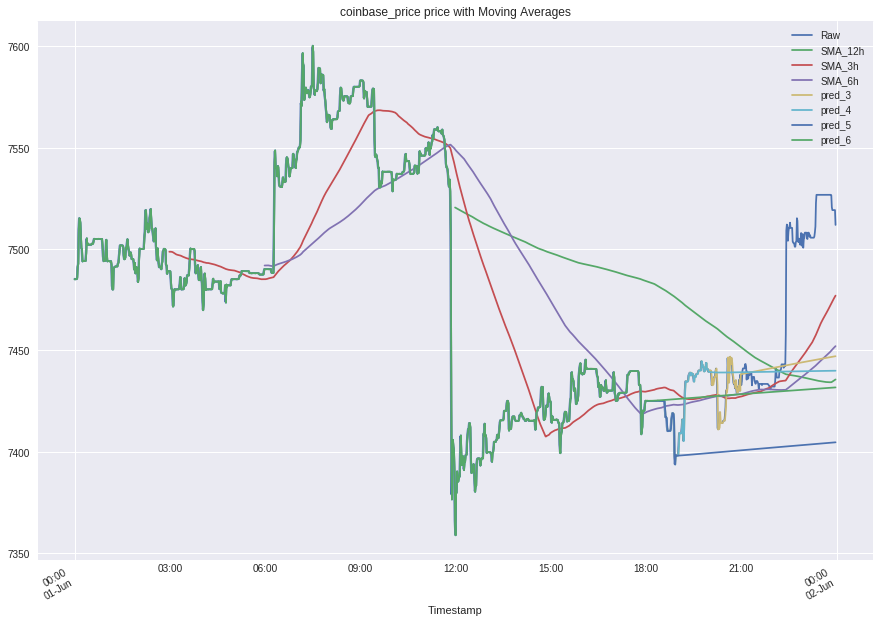

In [66]:
# moving Averages

sma_a = df.coinbase_price.rolling(180).mean()
sma_b = df.coinbase_price.rolling(360).mean()
sma_c = df.coinbase_price.rolling(720).mean()
pred_3 = df_result.iloc[:,[1,4]]
pred_4 = df_result.iloc[:,[1,7]]
pred_5 = df_result.iloc[:,[1,10]]
pred_6 = df_result.iloc[:,[1,13]]
#pred_12 = df_result.iloc[:,[1,16]]

smaplot = pd.DataFrame({'Raw': df.coinbase_price, 'SMA_3h': sma_a, 'SMA_6h': sma_b, 'SMA_12h': sma_c})

smaplot['pred_3']= pred_3.coinbase_price_pred_3.values
smaplot['pred_4']= pred_4.coinbase_price_pred_4.values
smaplot['pred_5']= pred_5.coinbase_price_pred_5.values
smaplot['pred_6']= pred_6.coinbase_price_pred_6.values
#smaplot['pred_12']= pred_12.coinbase_price_pred_12.values

smaplot.plot(figsize=(15, 11), legend=True, title="coinbase_price price with Moving Averages")

plt.gcf().autofmt_xdate()
plt.show()

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [69]:
import plotly
import plotly.graph_objs as go
import plotly.offline as offline

configure_plotly_browser_state()
offline.init_notebook_mode()

# Create a trace
trace = go.Scatter(x = smaplot.index,y = smaplot.Raw,name = 'RAW')
trace1 = go.Scatter(x = smaplot.index,y = smaplot.SMA_3h,name = 'MA_3h')
trace2 = go.Scatter(x = smaplot.index,y = smaplot.SMA_6h,name = 'MA_6h')
trace3 = go.Scatter(x = smaplot.index,y = smaplot.SMA_12h,name = 'MA_12h')
trace4 = go.Scatter(x = smaplot.index,y = smaplot.pred_3,name = 'wavenet_3h')
trace5 = go.Scatter(x = smaplot.index,y = smaplot.pred_4,name = 'wavenet_4h')
trace6 = go.Scatter(x = smaplot.index,y = smaplot.pred_5,name = 'wavenet_5h')
trace7 = go.Scatter(x = smaplot.index,y = smaplot.pred_6,name = 'wavenet_6h')

data = [trace,trace1,trace2,trace3,trace4,trace5,trace6,trace7]
plotly.offline.iplot(data, filename='basic-line')


## **3 시간 후 예측**

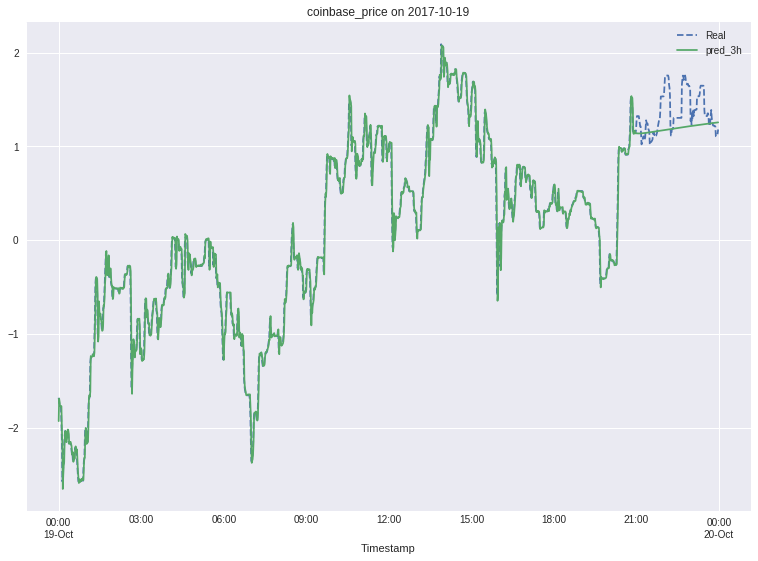

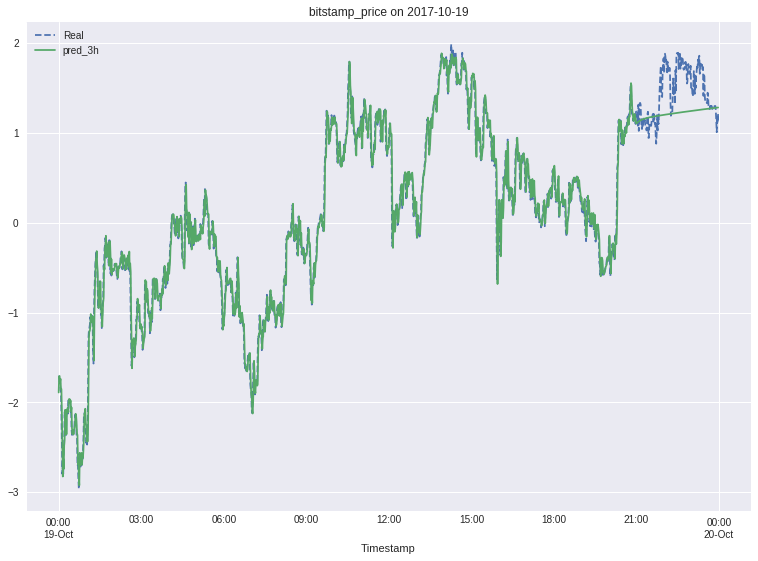

In [47]:
# Merge outputs together
for col in input_columns:
    train_target[col + '_pred'] = np.reshape(output[col], (-1,))
    test_target[col + '_pred'] = np.reshape(pred[col], (-1,))
    
df = (
    train_target
    .append(test_target)
    .pipe(lambda x: norm.undo_transform(x, suffix='_pred'))
)

for col in input_columns:
    fig = plt.figure(figsize=(13, 9))
    df[col].plot(label='Real', ls='--')
    df[col + '_pred'].plot(label='pred')
    plt.title(col + " on " + date.strftime("%Y-%m-%d"))
    plt.legend()
    plt.show()
    

## **6 시간 후 예측**

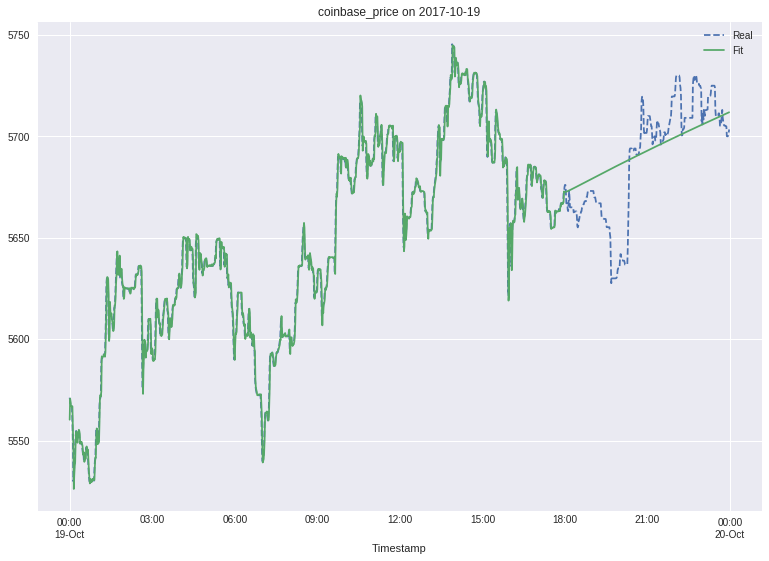

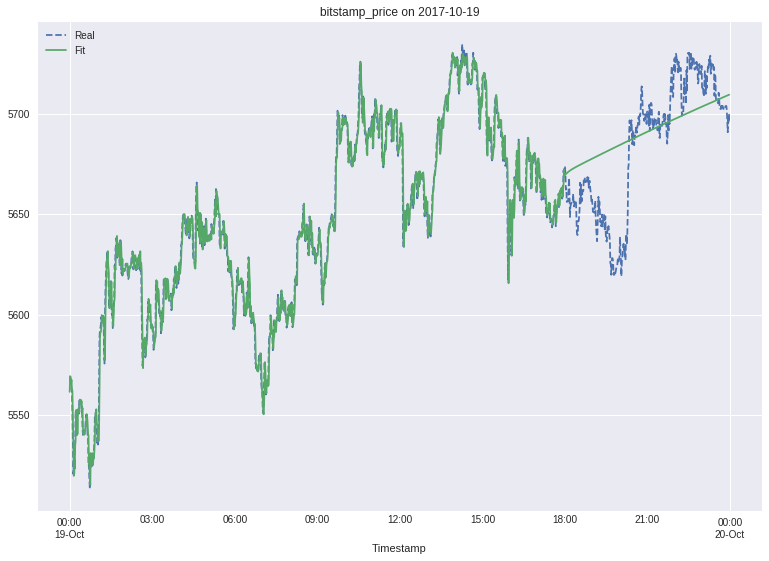

In [17]:
# Merge outputs together
for col in input_columns:
    train_target[col + '_pred'] = np.reshape(output[col], (-1,))
    test_target[col + '_pred'] = np.reshape(pred[col], (-1,))
df_6 = (
    train_target
    .append(test_target)
    .pipe(lambda x: norm.undo_transform(x, suffix='_pred'))
)

for col in input_columns:
    fig = plt.figure(figsize=(13, 9))
    df_6[col].plot(label='Real', ls='--')
    df_6[col + '_pred'].plot(label='Fit')
    plt.title(col + " on " + date.strftime("%Y-%m-%d"))
    plt.legend()
    plt.show()

## **12 시간 후 예측**

In [0]:
# Merge outputs together
for col in input_columns:
    train_target[col + '_pred'] = np.reshape(output[col], (-1,))
    test_target[col + '_pred'] = np.reshape(pred[col], (-1,))
df_12 = (
    train_target
    .append(test_target)
    .pipe(lambda x: norm.undo_transform(x, suffix='_pred'))
)

for col in input_columns:
    fig = plt.figure(figsize=(13, 9))
    df_12[col].plot(label='Real', ls='--')
    df_12[col + '_pred'].plot(label='Fit')
    plt.title(col + " on " + date.strftime("%Y-%m-%d"))
    plt.legend()
    plt.show()